In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from networks import *
from BS_generator import *

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class Net_LV(nn.Module):
    """
    Calibration of LV model: dS_t = S_t*r*dt + L(t,S_t,theta)dW_t to vanilla prices at different maturities.
    """
    def __init__(self, dim, timegrid, strikes_call, n_layers, vNetWidth, device, rate, maturities, n_maturities):
        super(Net_LV, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.maturities = maturities
        self.rate = rate
        
       
        self.diffusion = Net_timegrid(dim=dim+1, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth, 
                                      n_maturities=n_maturities, activation_output="softplus")
    
        self.control_variate_vanilla = Net_timegrid(dim=dim+1, nOut=len(strikes_call)*n_maturities, 
                                                   n_layers=3, vNetWidth=30, n_maturities=n_maturities)
        self.control_variate_exotics = Net_timegrid(dim=dim*len(self.timegrid)+1, nOut=1, n_layers=3, 
                                                   vNetWidth=20, n_maturities=n_maturities)
    
    def forward(self, S0, z, MC_samples, ind_T, period_length=30):
        ones = torch.ones(MC_samples, 1, device=self.device)
        path = torch.zeros(MC_samples, len(self.timegrid), device=self.device)
        S_old = ones * S0
        path[:, 0] = S_old.squeeze(1)
        
        cv_vanilla = torch.zeros(S_old.shape[0], len(self.strikes_call)*len(self.maturities), device=self.device)
        price_vanilla_cv = torch.zeros(len(self.maturities), len(self.strikes_call), device=self.device)
        var_price_vanilla_cv = torch.zeros_like(price_vanilla_cv)
        cv_exotics = torch.zeros(S_old.shape[0], 1, device=self.device)
        exotic_option_price = torch.zeros_like(S_old)
        running_max = S_old
        
        for i in range(1, ind_T+1):
            idx = (i-1) // period_length 
            t = torch.ones_like(S_old) * self.timegrid[i-1]
            h = self.timegrid[i] - self.timegrid[i-1]
            dW = (torch.sqrt(h) * z[:, i-1]).reshape(MC_samples, 1)
            diffusion = self.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
            S_new = S_old + self.rate * S_old * h/(1+self.rate*S_old.detach()*torch.sqrt(h)) \
                    + S_old*diffusion*dW/(1+S_old.detach()*diffusion.detach()*torch.sqrt(h))
            
            cv_vanilla += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() \
                           * self.control_variate_vanilla.forward_idx(idx, torch.cat([t, S_old.detach()], 1)) \
                           * dW.repeat(1, len(self.strikes_call)*len(self.maturities))
            cv_exotics += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() \
                          * self.control_variate_exotics.forward_idx(idx, torch.cat([t, path], 1)) * dW
            S_old = S_new
            path[:, i] = S_old.detach().squeeze(1)
            running_max = torch.max(running_max, S_old)
            if i in self.maturities:
                ind_maturity = self.maturities.index(i)
                for idx_strike, strike in enumerate(self.strikes_call):
                    cv = cv_vanilla.view(-1, len(self.maturities), len(self.strikes_call))
                    price_vanilla = torch.exp(-self.rate*self.timegrid[i]) * torch.clamp(S_old-strike, 0).squeeze(1) \
                                    - cv[:, ind_maturity, idx_strike]
                    price_vanilla_cv[ind_maturity, idx_strike] = price_vanilla.mean()
                    var_price_vanilla_cv[ind_maturity, idx_strike] = price_vanilla.var()
                    
        exotic_option_price = running_max - S_old
        error = torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price.detach() \
                - torch.mean(torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price.detach()) - cv_exotics.detach()
        exotic_option_price = torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price - cv_exotics
        
        return price_vanilla_cv, var_price_vanilla_cv, exotic_option_price, exotic_option_price.mean(), exotic_option_price.var(), error

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=1.5)
        
def train_nsde(model, z_test, config):

    loss_fn = nn.MSELoss()
    n_maturities = len(config["maturities"])
    model = model.to(device)
    model.apply(init_weights)
    params_SDE = list(model.diffusion.parameters())
    n_epochs = config["n_epochs"]
    T = config["maturities"][-1]
    
    target_mat_T = torch.tensor(config["target_data"][:n_maturities, :len(config["strikes_call"])],
                                device=device).float()
    
    optimizer_SDE = torch.optim.Adam(params_SDE, lr=0.001)
    optimizer_CV = torch.optim.Adam(list(model.control_variate_vanilla.parameters()) + 
                                    list(model.control_variate_exotics.parameters()), lr=0.001)
    scheduler_SDE = torch.optim.lr_scheduler.MultiStepLR(optimizer_SDE, milestones=[500,800], gamma=0.2)
    
    loss_val_best = 10
    itercount = 0
    
    rmse_list = []
    hedge_error_list = []
    
    for epoch in range(n_epochs):
        requires_grad_CV = (epoch+1) % 2 == 0
        if requires_grad_CV:
            model.control_variate_vanilla.unfreeze()
            model.control_variate_exotics.unfreeze()
            model.diffusion.freeze()
        else:
            model.diffusion.unfreeze()
            model.control_variate_vanilla.freeze()
            model.control_variate_exotics.freeze()
        
        print('Epoch:', epoch)
        batch_size = config["batch_size"]
        for i in range(0, 20*batch_size, batch_size):
            batch_z = torch.randn(batch_size, config["n_steps"], device=device)
            optimizer_SDE.zero_grad()
            optimizer_CV.zero_grad()
            
            pred, var, _, exotic_option_price, exotic_option_var, error = model(S0, batch_z, batch_size, T, period_length=16)
            itercount += 1
            if requires_grad_CV:
                loss = var.sum() + exotic_option_var
                loss.backward()
                nn.utils.clip_grad_norm_(list(model.control_variate_vanilla.parameters()) + 
                                           list(model.control_variate_exotics.parameters()), 3)
                optimizer_CV.step()
            else:
                MSE = loss_fn(pred, target_mat_T)
                loss = MSE
                loss.backward()
                nn.utils.clip_grad_norm_(params_SDE, 5)
                optimizer_SDE.step()
        
        scheduler_SDE.step()
        
        with torch.no_grad():
            pred, _, exotic_option_price, exotic_price_mean, exotic_price_var, error = \
                        model(S0, z_test, z_test.shape[0], T, period_length=16)
            
        
        error_hedge = error
        error_hedge_2 = torch.mean(error_hedge**2)
        error_hedge_inf = torch.max(torch.abs(error_hedge))
        print(f"Epoch {epoch}: Hedge MSE = {error_hedge_2.item():.4f}, Hedge max error = {error_hedge_inf.item():.4f}")
        
        MSE = loss_fn(pred, target_mat_T)
        loss_val = torch.sqrt(MSE)
        print(f"Epoch {epoch}: RMSE = {loss_val.item():.4f}")
        
        rmse_list.append(loss_val.item())
        hedge_error_list.append(error_hedge_2.item())
        
        if loss_val < loss_val_best:
            model_best = model
            loss_val_best = loss_val
        
       
        if loss_val.item() < 2e-5:
            break
    
    return model_best, rmse_list, hedge_error_list



In [13]:



S = 1.0
r_value = 0.025
sigma_value = 0.2
strikes_call = np.arange(0.8, 1.21, 0.02)


n_steps = 96
timegrid = torch.linspace(0, 1, n_steps+1)
timegrid_np = np.linspace(0, 1, n_steps+1)


maturity_indices = [16, 32, 48, 64]
maturities_times = timegrid_np[maturity_indices]


target_data = generate_option_prices(S, r_value, sigma_value, maturities_times, strikes_call, option_type='call')

maturities = list(range(16, 65, 16))
n_maturities = len(maturities)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



S0 = 1.0


MC_samples_test = 200000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)

CONFIG = {
    "batch_size": 20000,
    "n_epochs": 50 ,
    "maturities": maturities,
    "n_maturities": n_maturities,
    "strikes_call": strikes_call,
    "timegrid": timegrid,
    "n_steps": n_steps,
    "target_data": target_data
}


Using device: cuda:0


In [14]:

model = Net_LV(dim=1, timegrid=timegrid, strikes_call=strikes_call, n_layers=4, vNetWidth=50, 
               device=device, rate=r_value, maturities=maturities, n_maturities=n_maturities)
model, rmse_list, hedge_error_list = train_nsde(model, z_test, CONFIG)


Epoch: 0
Epoch 0: Hedge MSE = 0.0081, Hedge max error = 0.5522
Epoch 0: RMSE = 0.0098
Epoch: 1
Epoch 1: Hedge MSE = 0.0018, Hedge max error = 0.4175
Epoch 1: RMSE = 0.0098
Epoch: 2
Epoch 2: Hedge MSE = 0.0020, Hedge max error = 0.4294
Epoch 2: RMSE = 0.0086
Epoch: 3
Epoch 3: Hedge MSE = 0.0017, Hedge max error = 0.3452
Epoch 3: RMSE = 0.0086
Epoch: 4
Epoch 4: Hedge MSE = 0.0027, Hedge max error = 0.4181
Epoch 4: RMSE = 0.0051
Epoch: 5
Epoch 5: Hedge MSE = 0.0023, Hedge max error = 0.3677
Epoch 5: RMSE = 0.0051
Epoch: 6
Epoch 6: Hedge MSE = 0.0019, Hedge max error = 0.3162
Epoch 6: RMSE = 0.0033
Epoch: 7
Epoch 7: Hedge MSE = 0.0017, Hedge max error = 0.3092
Epoch 7: RMSE = 0.0033
Epoch: 8
Epoch 8: Hedge MSE = 0.0017, Hedge max error = 0.3219
Epoch 8: RMSE = 0.0030
Epoch: 9
Epoch 9: Hedge MSE = 0.0016, Hedge max error = 0.2825
Epoch 9: RMSE = 0.0030
Epoch: 10
Epoch 10: Hedge MSE = 0.0019, Hedge max error = 0.3628
Epoch 10: RMSE = 0.0025
Epoch: 11
Epoch 11: Hedge MSE = 0.0017, Hedge max e

Estimated sigma from neural SDE (MC average of diffusion values): 0.18681775
True sigma: 0.2


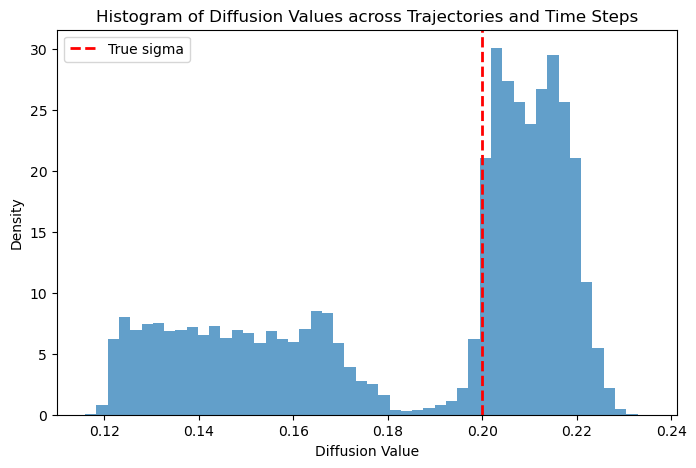

In [ ]:


def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):
   
    model.eval() 
    diffusion_vals = [] 
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    
    for i in range(1, n_steps+1):
        idx = (i-1) // period_length
        t = torch.ones_like(S_old) * timegrid[i-1]
        # Compute diffusion value from the trained diffusion network
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        
        # Simulate the SDE step (same as in the forward method)
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h/(1 + r_value * S_old.detach()*torch.sqrt(h)) \
                     + S_old * diffusion * dW/(1 + S_old.detach()*diffusion.detach()*torch.sqrt(h))
        S_old = S_new
    
    # Stack diffusion values from each time step: shape (MC_samples, n_steps)
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals

# Use a moderate number of trajectories for the simulation
MC_samples_sim = 10000
diff_vals = simulate_diffusion(model, S0, MC_samples_sim, n_steps, period_length=30)

# Compute the Monte Carlo estimate of sigma: average of all diffusion values
estimated_sigma = np.mean(diff_vals)
print("Estimated sigma from neural SDE (MC average of diffusion values):", estimated_sigma)
print("True sigma:", sigma_value)

# Optional: Plot a histogram of the diffusion values to visualize the distribution
plt.figure(figsize=(8,5))
plt.hist(diff_vals.flatten(), bins=50, density=True, alpha=0.7)
plt.axvline(sigma_value, color='red', linestyle='dashed', linewidth=2, label='True sigma')
plt.xlabel("Diffusion Value")
plt.ylabel("Density")
plt.title("Histogram of Diffusion Values across Trajectories and Time Steps")
plt.legend()
plt.show()


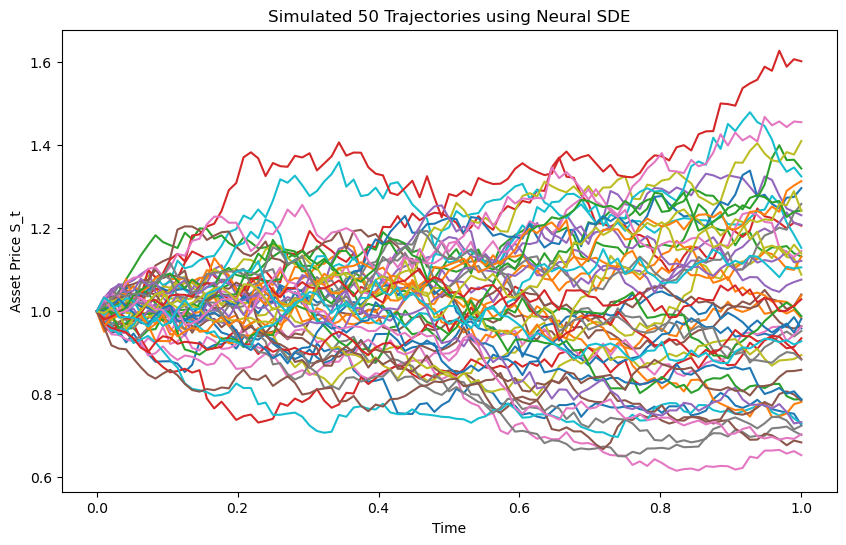

In [ ]:
def simulate_paths(model, S0, MC_samples, n_steps, period_length=16):
    model.eval()  
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    paths = torch.zeros(MC_samples, n_steps+1, device=device)
    paths[:, 0] = S_old.squeeze(1)
    
    for i in range(1, n_steps+1):

        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        h = timegrid[i] - timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach() * torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        paths[:, i] = S_new.squeeze(1)
        S_old = S_new
    return paths.detach().cpu().numpy()


MC_samples_sim_paths = 50
simulated_paths = simulate_paths(model, S0, MC_samples_sim_paths, n_steps, period_length=16)
RMSE = 0.0002

time_points = timegrid.cpu().numpy()



plt.figure(figsize=(10, 6))
for i in range(MC_samples_sim_paths):
    plt.plot(time_points, simulated_paths[i, :], lw=1.5)
plt.xlabel("Time")
plt.ylabel("Asset Price S_t")
plt.title("Simulated 50 Trajectories using Neural SDE")
plt.show()


In [17]:
def predict_sigma_direct(model):
    """
    Method 1: Direct evaluation of the diffusion network at (t=0, S=1).
    """
    # At t=0, timegrid[0] is 0; use index 0 for the network.
    t = torch.tensor([[timegrid[0]]], device=device)
    S_val = torch.tensor([[1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, torch.cat([t, S_val], 1))
    return sigma_pred.item()

def predict_sigma_via_trajectories(model, S0=1.0, n_steps=96, period_length=16, MC_samples=1000):
    """
    Method 2: Simulate trajectories and use the Monte Carlo average of the diffusion values.
    """
    model.eval()
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    diffusion_vals = []
    for i in range(1, n_steps+1):
        # Clamp index to ensure it does not exceed available networks
        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + 0.025 * S_old * h / (1 + 0.025 * S_old.detach() * torch.sqrt(h)) \
                + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        S_old = S_new
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    sigma_traj = np.mean(diffusion_vals)
    return sigma_traj


=== Training model for sigma = 0.02 ===
Epoch: 0
Epoch 0: Hedge MSE = 0.0009, Hedge max error = 0.1505
Epoch 0: RMSE = 0.0012
Epoch: 1
Epoch 1: Hedge MSE = 0.0001, Hedge max error = 0.0591
Epoch 1: RMSE = 0.0012
Epoch: 2
Epoch 2: Hedge MSE = 0.0000, Hedge max error = 0.0332
Epoch 2: RMSE = 0.0002
Epoch: 3
Epoch 3: Hedge MSE = 0.0000, Hedge max error = 0.0303
Epoch 3: RMSE = 0.0002
Epoch: 4
Epoch 4: Hedge MSE = 0.0000, Hedge max error = 0.0269
Epoch 4: RMSE = 0.0001
Epoch: 5
Epoch 5: Hedge MSE = 0.0000, Hedge max error = 0.0266
Epoch 5: RMSE = 0.0001
Epoch: 6
Epoch 6: Hedge MSE = 0.0000, Hedge max error = 0.0259
Epoch 6: RMSE = 0.0001
Epoch: 7
Epoch 7: Hedge MSE = 0.0000, Hedge max error = 0.0260
Epoch 7: RMSE = 0.0001
Epoch: 8
Epoch 8: Hedge MSE = 0.0000, Hedge max error = 0.0258
Epoch 8: RMSE = 0.0001
Epoch: 9
Epoch 9: Hedge MSE = 0.0000, Hedge max error = 0.0258
Epoch 9: RMSE = 0.0001
Epoch: 10
Epoch 10: Hedge MSE = 0.0000, Hedge max error = 0.0256
Epoch 10: RMSE = 0.0001
Epoch: 11


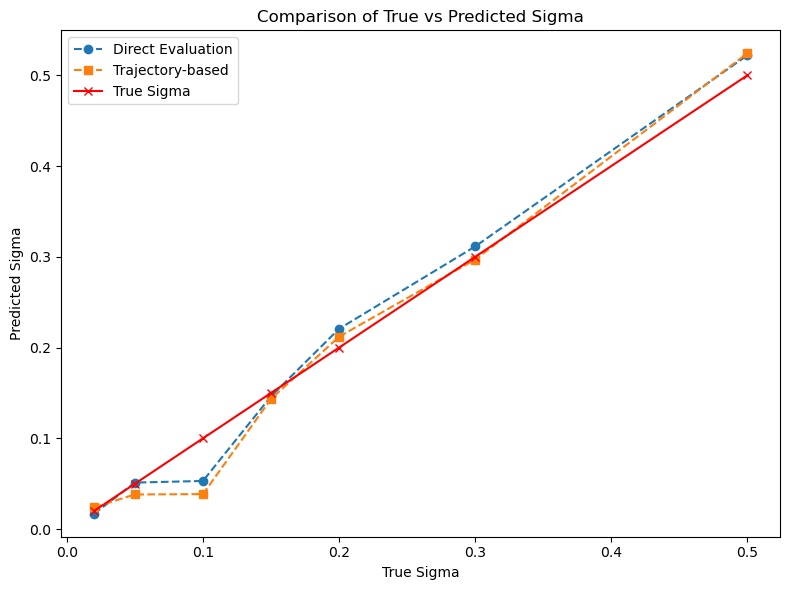

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from BS_generator import generate_option_prices 
from networks import Net_timegrid                



strikes_call = np.arange(0.8, 1.21, 0.02)
n_steps = 96
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
timegrid = torch.linspace(0, 1, n_steps+1).to(device)
maturities = list(range(16, 64, 16))  
n_maturities = len(maturities)
r_value = 0.025

MC_samples_test = 20000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)


def predict_sigma_direct(model):
    model.eval()
    input_tensor = torch.tensor([[0.0, 1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, input_tensor)
    return sigma_pred.item()

def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):
    model.eval()
    diffusion_vals = []  
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    
    for i in range(1, n_steps+1):
        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach() * torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        S_old = S_new
        
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals

def predict_sigma_via_trajectories(model, S0, n_steps, period_length, MC_samples):
    diff_vals = simulate_diffusion(model, S0, MC_samples, n_steps, period_length)
    sigma_estimate = np.mean(diff_vals)
    return sigma_estimate



sigmas = [0.02, 0.05, 0.1, 0.15, 0.2,  0.3, 0.5]
results_direct = {}
results_traj = {}


maturities_time = [timegrid[m].item() for m in maturities]

for sigma in sigmas:
    print(f"\n=== Training model for sigma = {sigma} ===")
    

    option_prices = generate_option_prices(1, r_value, sigma, maturities_time, strikes_call)
    
    CONFIG = {
        "batch_size": 1000,
        "n_epochs": 20,
        "maturities": maturities,        
        "n_maturities": n_maturities,
        "strikes_call": strikes_call,
        "timegrid": timegrid,
        "n_steps": n_steps,
        "target_data": option_prices,
    }
    

    model = Net_LV(dim=1, timegrid=timegrid, strikes_call=strikes_call, n_layers=5,
                   vNetWidth=50, device=device, n_maturities=n_maturities,
                   maturities=maturities, rate=r_value)
    model.to(device)
    model.apply(init_weights)
    

    z_test = torch.randn(20000, n_steps, device=device)
    z_test = torch.cat([z_test, -z_test], 0)
    

    model, _, _ = train_nsde(model, z_test, CONFIG)
    

    sigma_direct = predict_sigma_direct(model)
    results_direct[sigma] = sigma_direct
    print(f"Direct Evaluation --> True sigma: {sigma} \t Predicted sigma: {sigma_direct}")
    

    sigma_traj = predict_sigma_via_trajectories(model, S0=1.0, n_steps=n_steps, period_length=16, MC_samples=1000)
    results_traj[sigma] = sigma_traj
    print(f"Trajectory-based  --> True sigma: {sigma} \t Predicted sigma (averaged): {sigma_traj}")


true_sigmas = list(results_direct.keys())
predicted_direct = [results_direct[s] for s in true_sigmas]
predicted_traj = [results_traj[s] for s in true_sigmas]

plt.figure(figsize=(8, 6))
plt.plot(true_sigmas, predicted_direct, marker='o', linestyle='--', label="Direct Evaluation")
plt.plot(true_sigmas, predicted_traj, marker='s', linestyle='--', label="Trajectory-based")
plt.plot(true_sigmas, true_sigmas, marker='x', color='red', label="True Sigma")
plt.xlabel("True Sigma")
plt.ylabel("Predicted Sigma")
plt.title("Comparison of True vs Predicted Sigma")
plt.legend()
plt.tight_layout()
plt.show()



Available expirations: ('2025-03-13', '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-28', '2025-03-31', '2025-04-04', '2025-04-11', '2025-04-17', '2025-04-25', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Selected monthly expirations: ['2025-03-31', '2025-04-30', '2025-05-30', '2025-06-30', '2025-07-31', '2025-08-29']
Days to expiration for selected expirations: [18, 48, 78, 109, 140, 169]
Maturity indices on timegrid: [1, 2, 3, 4, 5, 6]
Shape of target_data (real option prices): (6, 25)
Epoch: 0
Epoch 0: Hedge MSE = 0.0510, Hedge max error = 1.0447
Epoch 0: RMSE = 0.0249
Epoch: 1
Epoch 1: Hedge MSE = 0.0083, Hedge max error = 0.5415
Epoch 1: RMSE = 0.0249
Epoch: 2
Epoch 2: Hedge MSE = 0.0085, Hedge max error = 0.5406
Epoch

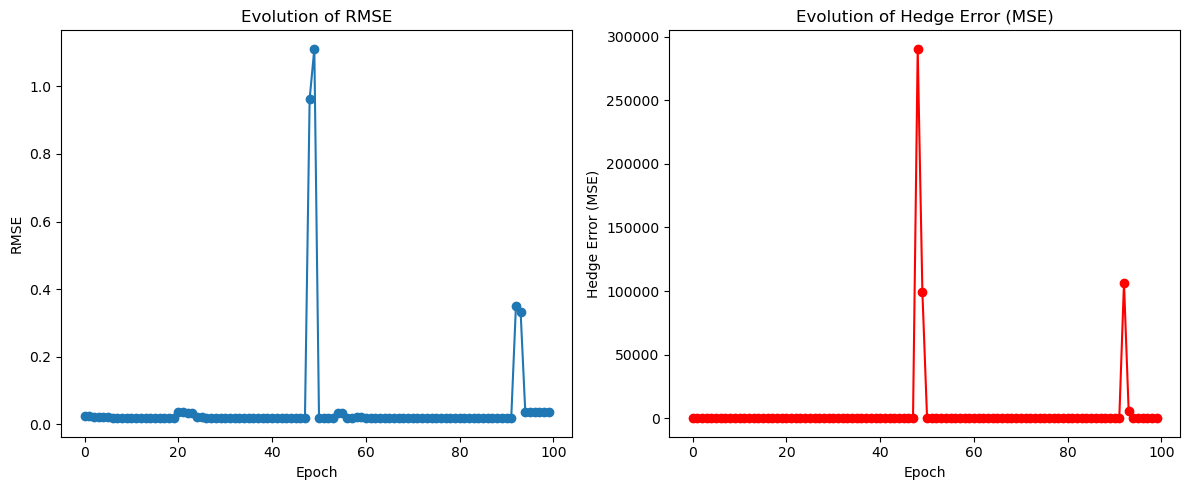

In [ ]:
import yfinance as yf
import datetime
from collections import defaultdict


ticker_symbol = "SPY"
ticker = yf.Ticker(ticker_symbol)
expirations = ticker.options
print("Available expirations:", expirations)

exp_by_month = defaultdict(list)
for exp in expirations:
    date_obj = datetime.datetime.strptime(exp, "%Y-%m-%d").date()
    key = (date_obj.year, date_obj.month)
    exp_by_month[key].append(exp)


monthly_exps = []
for key in sorted(exp_by_month.keys()):
    monthly_exps.append(sorted(exp_by_month[key])[-1])


num_exps = 6
selected_exps = monthly_exps[:num_exps]
print("Selected monthly expirations:", selected_exps)


current_date = datetime.datetime.now().date()
expiration_dates = [datetime.datetime.strptime(exp, "%Y-%m-%d").date() for exp in selected_exps]
T_days = [(exp_date - current_date).days for exp_date in expiration_dates]
print("Days to expiration for selected expirations:", T_days)


n_steps = 96
timegrid = torch.linspace(0, 1, n_steps+1).to(device)

maturities = [1, 2, 3, 4, 5, 6]
n_maturities = len(maturities)
print("Maturity indices on timegrid:", maturities)


normalized_strikes_target = np.linspace(0.8, 1.2, 25)

target_data_list = []
for exp in selected_exps:
    option_chain = ticker.option_chain(exp)
    calls = option_chain.calls
    underlying_price = ticker.info['regularMarketPrice']
   
    mask = (calls['strike'] >= 0.8 * underlying_price) & (calls['strike'] <= 1.2 * underlying_price)
    calls_filtered = calls[mask]
    norm_strikes = calls_filtered['strike'].values / underlying_price
    norm_prices = calls_filtered['lastPrice'].values / underlying_price
    
    sort_idx = np.argsort(norm_strikes)
    norm_strikes = norm_strikes[sort_idx]
    norm_prices = norm_prices[sort_idx]

    interp_prices = np.interp(normalized_strikes_target, norm_strikes, norm_prices)
    target_data_list.append(interp_prices)

target_data = np.array(target_data_list) 
print("Shape of target_data (real option prices):", target_data.shape)

assert target_data.shape[0] == n_maturities, "Mismatch: number of target maturities and computed maturities differ!"


CONFIG_real = {
    "batch_size": 5000,
    "n_epochs": 100,            
    "maturities": maturities,  
    "n_maturities": n_maturities,
    "strikes_call": normalized_strikes_target,
    "timegrid": timegrid,
    "n_steps": n_steps,
    "target_data": target_data, 
}

model_real = Net_LV(dim=1, timegrid=timegrid, strikes_call=normalized_strikes_target, n_layers=5,
                    vNetWidth=50, device=device, n_maturities=n_maturities,
                    maturities=maturities, rate=0.025)
model_real.to(device)
model_real.apply(init_weights)


MC_samples_real = 20000
z_test_real = torch.randn(MC_samples_real, n_steps, device=device)
z_test_real = torch.cat([z_test_real, -z_test_real], 0)


model_real, rmse_list, hedge_error_list = train_nsde(model_real, z_test_real, CONFIG_real)


epochs = range(len(rmse_list))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, rmse_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE")
plt.subplot(1, 2, 2)
plt.plot(epochs, hedge_error_list, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Hedge Error (MSE)")
plt.title("Evolution of Hedge Error (MSE)")
plt.tight_layout()
plt.show()


with torch.no_grad():
    pred, _, _, _, _, _ = model_real(1.0, z_test_real, z_test_real.shape[0], maturities[-1], period_length=16)

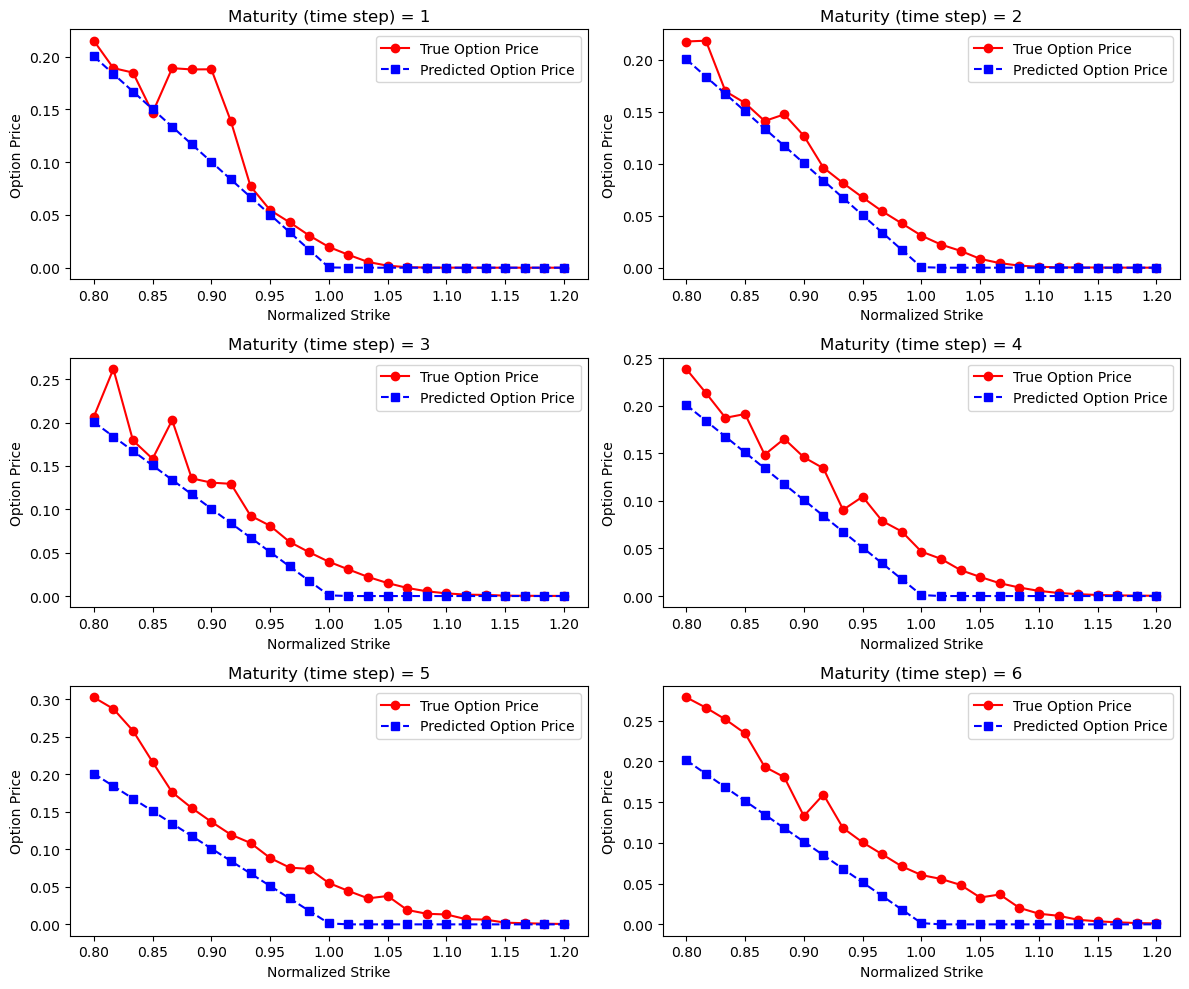

In [20]:
plt.figure(figsize=(12, 10))
for i, m in enumerate(maturities):
    plt.subplot(3, 2, i+1)
    plt.plot(normalized_strikes_target, target_data[i, :], 'ro-', label="True Option Price")
    plt.plot(normalized_strikes_target, pred[i, :].cpu().numpy(), 'bs--', label="Predicted Option Price")
    plt.title(f"Maturity (time step) = {m}")
    plt.xlabel("Normalized Strike")
    plt.ylabel("Option Price")
    plt.legend()
plt.tight_layout()
plt.show()
